### Cell 1: Project Title & Description

# Twitter Named Entity Recognition (NER) Project

This project aims to identify named entities in tweets using both classical (BiLSTM+CRF) and modern (BERT) NLP approaches. The dataset is in CoNLL format with fine-grained entity labels.


### Cell 2: Imports (Structured and Commented)

In [1]:
# ==== Data Handling ====
import pandas as pd
import numpy as np
from collections import Counter
import os

# ==== Visualization ====
import matplotlib.pyplot as plt
import seaborn as sns

# ==== NLP Utilities ====
import re

# ==== System Config ====
import warnings
warnings.filterwarnings("ignore")

# For reading CoNLL format
from pathlib import Path

# tokenizer and padder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



### Cell 3: Load & Parse CoNLL Dataset

In [2]:
def parse_conll(file_path):
    sentences = []
    sentence = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                parts = line.split()
                if len(parts) >= 2:
                    word, tag = parts[0], parts[-1]
                    sentence.append((word, tag))
    if sentence:
        sentences.append(sentence)
    return sentences

# Load training and test datasets
train_path = r"C:\Users\VEERANNA\Twitter_NER_NLP_project\wnut 16.txt.conll"
test_path = r"C:\Users\VEERANNA\Twitter_NER_NLP_project\wnut 16test.txt.conll"

train_sentences = parse_conll(train_path)
test_sentences = parse_conll(test_path)

# Preview one sentence
train_sentences[0][:10]


[('@SammieLynnsMom', 'O'),
 ('@tg10781', 'O'),
 ('they', 'O'),
 ('will', 'O'),
 ('be', 'O'),
 ('all', 'O'),
 ('done', 'O'),
 ('by', 'O'),
 ('Sunday', 'O'),
 ('trust', 'O')]

### Cell 4: Tag Distribution Visualization

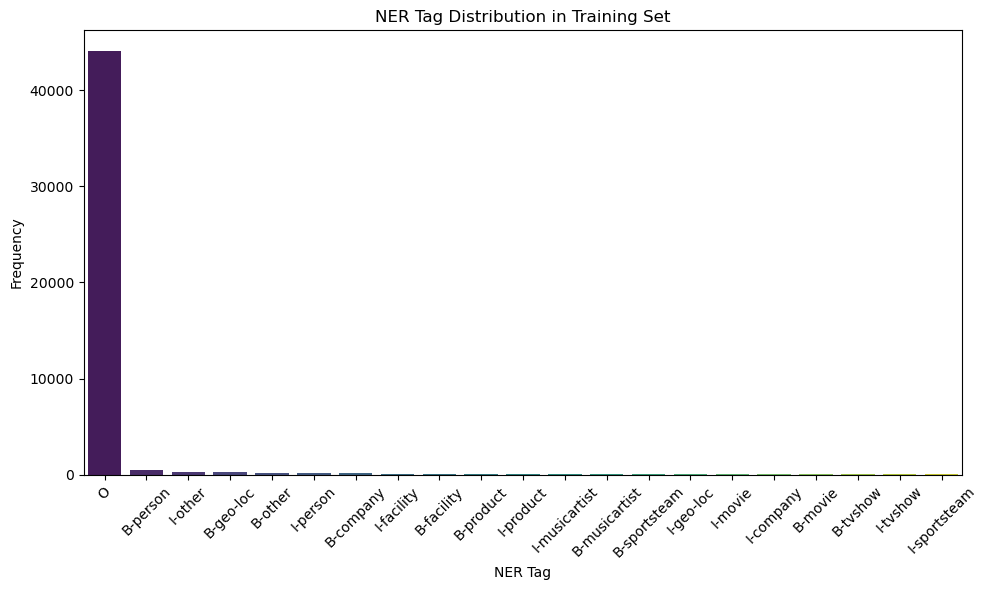

,Tag,Count
0,O,44007
8,B-person,449
10,I-other,320
1,B-geo-loc,276
9,B-other,225
15,I-person,215
6,B-company,171
3,I-facility,105
2,B-facility,104
7,B-product,97


In [3]:
all_tags = [tag for sentence in train_sentences for _, tag in sentence]
tag_counts = Counter(all_tags)

tag_df = pd.DataFrame(tag_counts.items(), columns=['Tag', 'Count']).sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=tag_df, x='Tag', y='Count', palette='viridis')
plt.title('NER Tag Distribution in Training Set')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.xlabel('NER Tag')
plt.tight_layout()
plt.show()

tag_df


### Cell 5: Extract Tokens and Labels

In [4]:
# Extract token and tag sequences
def extract_tokens_and_labels(sentences):
    tokens = [[word for word, tag in sentence] for sentence in sentences]
    labels = [[tag for word, tag in sentence] for sentence in sentences]
    return tokens, labels

X_train, y_train = extract_tokens_and_labels(train_sentences)
X_test, y_test = extract_tokens_and_labels(test_sentences)

# Preview
print("Example tokens:", X_train[0][:10])
print("Example labels:", y_train[0][:10])
    

Example tokens: ['@SammieLynnsMom', '@tg10781', 'they', 'will', 'be', 'all', 'done', 'by', 'Sunday', 'trust']
Example labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### Cell 6: Build Tag ↔ Index Mapping

In [5]:
# Flatten all tags from training data
all_tags = [tag for sentence in y_train for tag in sentence]

# Unique tags sorted
unique_tags = sorted(set(all_tags))

# Create mappings
tag2idx = {tag: idx for idx, tag in enumerate(unique_tags)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

print("Number of unique tags:", len(tag2idx))
print("Sample tag-to-index mapping:", tag2idx)


Number of unique tags: 21
Sample tag-to-index mapping: {'B-company': 0, 'B-facility': 1, 'B-geo-loc': 2, 'B-movie': 3, 'B-musicartist': 4, 'B-other': 5, 'B-person': 6, 'B-product': 7, 'B-sportsteam': 8, 'B-tvshow': 9, 'I-company': 10, 'I-facility': 11, 'I-geo-loc': 12, 'I-movie': 13, 'I-musicartist': 14, 'I-other': 15, 'I-person': 16, 'I-product': 17, 'I-sportsteam': 18, 'I-tvshow': 19, 'O': 20}


### Cell 7: Pad Tokens and Labels

In [6]:
MAX_LEN = max(len(seq) for seq in X_train)
print("Maximum sentence length:", MAX_LEN)


Maximum sentence length: 39


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fit tokenizer on all tokens
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(X_train)

# Convert words to integer sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')


### Cell 8: Encode & Pad Labels

In [8]:
# Encode labels using tag2idx
def encode_labels(labels, tag2idx, max_len):
    label_seq = [[tag2idx[tag] for tag in seq] for seq in labels]
    padded = pad_sequences(label_seq, maxlen=max_len, padding='post', value=tag2idx['O'])
    return padded

y_train_pad = encode_labels(y_train, tag2idx, MAX_LEN)
y_test_pad = encode_labels(y_test, tag2idx, MAX_LEN)


In [9]:
print("Encoded and padded X shape:", X_train_pad.shape)
print("Encoded and padded y shape:", y_train_pad.shape)
print("First padded sentence:", X_train_pad[0][:10])
print("First padded labels:  ", y_train_pad[0][:10])


Encoded and padded X shape: (2394, 39)
Encoded and padded y shape: (2394, 39)
First padded sentence: [2905 2906   87   50   30   44  222   97  113 1039]
First padded labels:   [20 20 20 20 20 20 20 20 20 20]


## Build & Train BiLSTM + CRF Model

### Cell 9.1: Install CRF Layer and Import Dependencies

In [10]:
!pip install tensorflow-addons


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense
import tensorflow_addons as tfa


In [12]:
# !pip install tensorflow==2.12.0
# !pip install tensorflow-addons==0.20.0


In [13]:
# !pip uninstall -y tensorflow
# !pip install tensorflow==2.12.0


In [14]:
# !pip install tensorflow-addons==0.20.0


### Cell 9.2: Build the BiLSTM + CRF Model

In [15]:
from tensorflow_addons.text import crf_log_likelihood
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense

# Parameters
input_dim = len(tokenizer.word_index) + 1
output_dim = 64
input_length = MAX_LEN
num_tags = len(tag2idx)

# Initialize transition parameters ONCE
transition_params = tf.Variable(
    tf.random.uniform(shape=(num_tags, num_tags)),
    trainable=True,
    name='transitions'
)

# Model architecture
input = Input(shape=(input_length,))
x = Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True)(input)
x = Bidirectional(LSTM(units=64, return_sequences=True))(x)
x = TimeDistributed(Dense(num_tags))(x)  # Raw logits for CRF

model = Model(inputs=input, outputs=x)

# Custom CRF Loss
def crf_loss_fn(y_true, y_pred):
    log_likelihood, _ = crf_log_likelihood(
        inputs=y_pred,
        tag_indices=tf.cast(y_true, dtype=tf.int32),
        sequence_lengths=tf.math.reduce_sum(tf.cast(tf.math.not_equal(y_true, 0), tf.int32), axis=1),
        transition_params=transition_params
    )
    return -tf.reduce_mean(log_likelihood)

# Custom CRF Accuracy
def sequence_accuracy(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0)
    correct_preds = tf.equal(tf.argmax(y_pred, axis=-1), tf.cast(y_true, tf.int64))
    correct_preds = tf.boolean_mask(correct_preds, mask)
    return tf.reduce_mean(tf.cast(correct_preds, tf.float32))

model.compile(optimizer='adam', loss=crf_loss_fn, metrics=[sequence_accuracy])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39)]              0         
                                                                 
 embedding (Embedding)       (None, 39, 64)            580480    
                                                                 
 bidirectional (Bidirectiona  (None, 39, 128)          66048     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 39, 21)           2709      
 ibuted)                                                         
                                                                 
Total params: 649,237
Trainable params: 649,237
Non-trainable params: 0
_________________________________________________________________


### Cell 9.3: Train the Model

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_sequence_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_pad, y_train_pad,
    batch_size=32,
    epochs=30,
    validation_data=(X_test_pad, y_test_pad),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
75/75 [==============================] - 30s 200ms/step - loss: 78.8158 - sequence_accuracy: 0.9607 - val_loss: 78.8580 - val_sequence_accuracy: 0.9642
Epoch 2/30
75/75 [==============================] - 10s 129ms/step - loss: 64.3746 - sequence_accuracy: 0.9753 - val_loss: 75.6096 - val_sequence_accuracy: 0.9642
Epoch 3/30
75/75 [==============================] - 8s 111ms/step - loss: 60.9764 - sequence_accuracy: 0.9753 - val_loss: 72.1723 - val_sequence_accuracy: 0.9642
Epoch 4/30
75/75 [==============================] - 8s 110ms/step - loss: 57.5224 - sequence_accuracy: 0.9754 - val_loss: 68.8646 - val_sequence_accuracy: 0.9642
Epoch 5/30
75/75 [==============================] - 8s 109ms/step - loss: 54.2752 - sequence_accuracy: 0.9753 - val_loss: 65.8171 - val_sequence_accuracy: 0.9642
Epoch 6/30
75/75 [==============================] - 9s 118ms/step - loss: 51.3351 - sequence_accuracy: 0.9757 - val_loss: 63.1344 - val_sequence_accuracy: 0.9641
Epoch 7/30
75/75 [========

### Cell 9.4 — Plotting Loss and Accuracy Curves

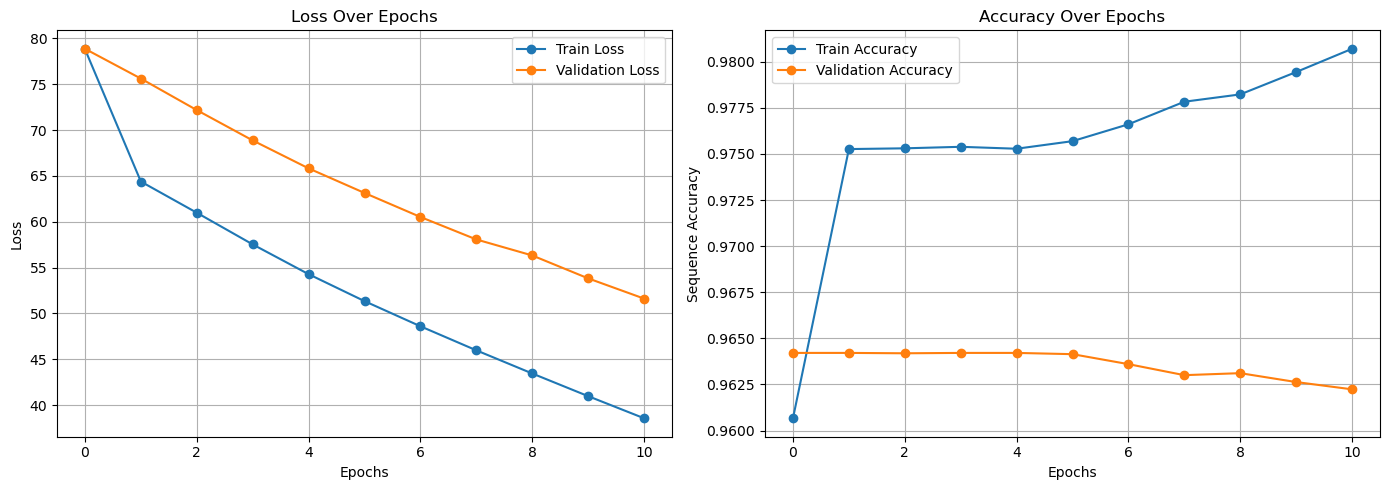

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Sequence Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['sequence_accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_sequence_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Sequence Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Cell 9.5 Evaluation 

In [18]:
# Generate predictions on test set
y_pred = model.predict(X_test_pad)


121/121 [==============================] - 4s 12ms/step



Classification Report:

               precision    recall  f1-score   support

   B-facility       0.00      0.00      0.00       253
    B-geo-loc       0.00      0.00      0.00       882
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.00      0.00      0.00       191
      B-other       0.00      0.00      0.00       584
     B-person       0.00      0.00      0.00       482
    B-product       0.00      0.00      0.00       246
 B-sportsteam       0.00      0.00      0.00       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.00      0.00      0.00       265
   I-facility       0.00      0.00      0.00       366
    I-geo-loc       0.00      0.00      0.00       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.00      0.00      0.00       140
      I-other       0.00      0.00      0.00       556
     I-person       0.00      0.00      0.00       300
    I-product       0.00      0.00     

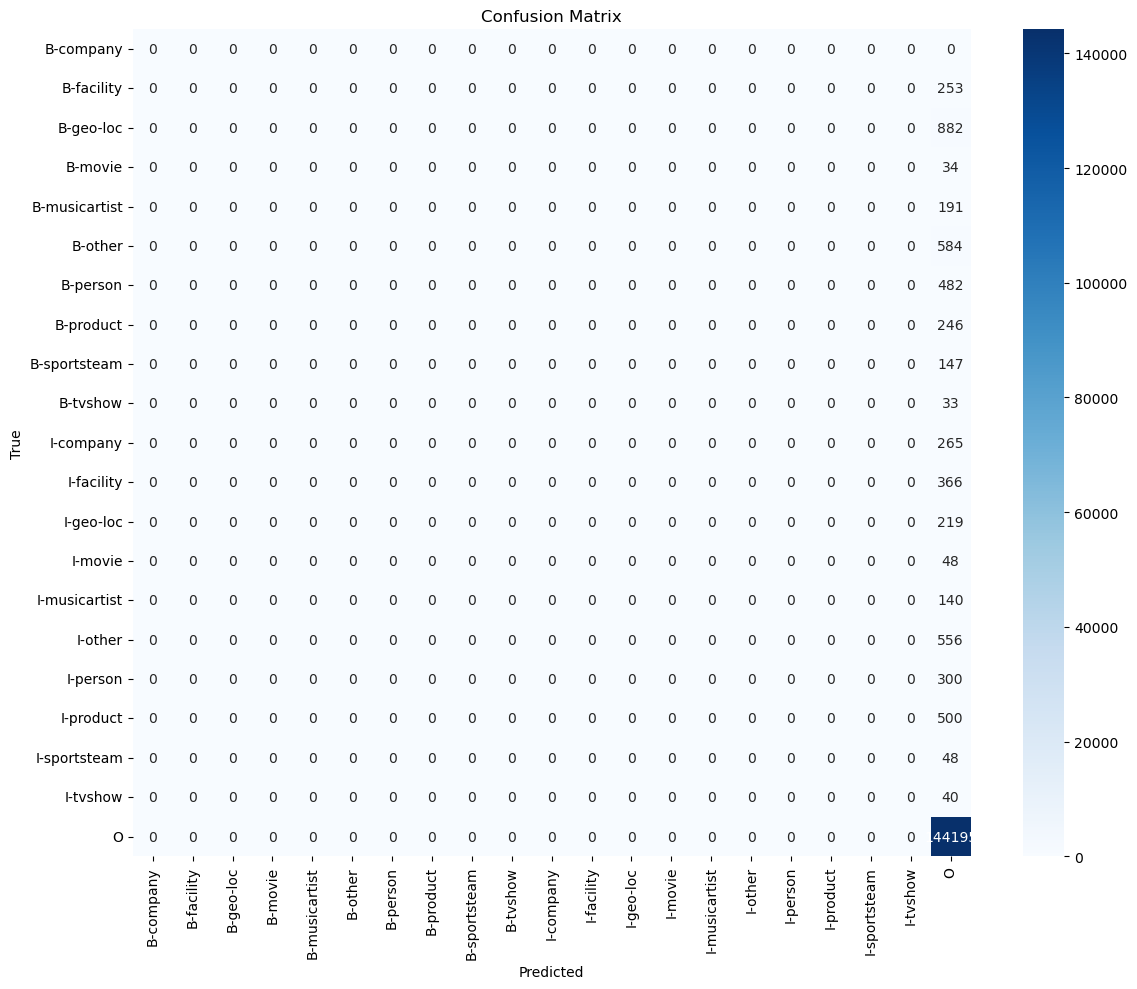

In [19]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Invert tag2idx for label conversion
inv_tag2idx = {v: k for k, v in tag2idx.items()}

# Flatten predictions and labels (ignoring padding tokens)
y_true_flat = []
y_pred_flat = []

for i in range(len(y_test_pad)):
    for j in range(len(y_test_pad[i])):
        if y_test_pad[i][j] != 0:  # Ignore padding
            y_true_flat.append(y_test_pad[i][j])
            y_pred_flat.append(np.argmax(y_pred[i][j]))

# Convert index to tag labels
y_true_labels = [inv_tag2idx[idx] for idx in y_true_flat]
y_pred_labels = [inv_tag2idx[idx] for idx in y_pred_flat]

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true_labels, y_pred_labels))

# Confusion Matrix
labels = list(tag2idx.keys())
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [20]:
# !pip install seqeval


In [21]:
from seqeval.metrics import classification_report as seqeval_classification_report


In [22]:
from seqeval.metrics import classification_report as seqeval_classification_report

# Convert indices back to tag strings
inv_tag2idx = {v: k for k, v in tag2idx.items()}

# Convert padded predictions to label format
y_true_seqeval = []
y_pred_seqeval = []

for true_seq, pred_seq in zip(y_test_pad, y_pred):
    true_tags = []
    pred_tags = []
    for true_tag_idx, pred_scores in zip(true_seq, pred_seq):
        if true_tag_idx != 0:  # ignore padding
            true_tags.append(inv_tag2idx[true_tag_idx])
            pred_tag_idx = np.argmax(pred_scores)
            pred_tags.append(inv_tag2idx[pred_tag_idx])
    y_true_seqeval.append(true_tags)
    y_pred_seqeval.append(pred_tags)


In [23]:
print("Seqeval Classification Report:\n")
print(seqeval_classification_report(y_true_seqeval, y_pred_seqeval))


Seqeval Classification Report:

              precision    recall  f1-score   support

     company       0.00      0.00      0.00       177
    facility       0.00      0.00      0.00       253
     geo-loc       0.00      0.00      0.00       882
       movie       0.00      0.00      0.00        34
 musicartist       0.00      0.00      0.00       191
       other       0.00      0.00      0.00       584
      person       0.00      0.00      0.00       482
     product       0.00      0.00      0.00       246
  sportsteam       0.00      0.00      0.00       147
      tvshow       0.00      0.00      0.00        33

   micro avg       0.00      0.00      0.00      3029
   macro avg       0.00      0.00      0.00      3029
weighted avg       0.00      0.00      0.00      3029



The seqeval report confirms that the BiLSTM + CRF model completely failed to extract any named entities, with 0.00 precision, recall, and F1-score across all 10 classes. This strongly reinforces the earlier observation: while the model appeared to have high token-level accuracy due to frequent 'O' predictions, it learned nothing meaningful for the actual NER task.

In [24]:
# check label distribution
import numpy as np
unique, counts = np.unique(y_train_pad, return_counts=True)
label_distribution = {inv_tag2idx[i]: c for i, c in zip(unique, counts)}
print("Label distribution in training data:\n", label_distribution)


Label distribution in training data:
 {'B-company': 171, 'B-facility': 104, 'B-geo-loc': 276, 'B-movie': 34, 'B-musicartist': 55, 'B-other': 225, 'B-person': 449, 'B-product': 97, 'B-sportsteam': 51, 'B-tvshow': 34, 'I-company': 36, 'I-facility': 105, 'I-geo-loc': 49, 'I-movie': 46, 'I-musicartist': 61, 'I-other': 320, 'I-person': 215, 'I-product': 80, 'I-sportsteam': 23, 'I-tvshow': 31, 'O': 90904}


# BERT

In [25]:
# 10.1 Install and Import Required Libraries

In [26]:
!pip install transformers datasets --quiet


In [27]:
from transformers import BertTokenizerFast


In [28]:
# 10.2 Load BERT Tokenizer

In [29]:
# Load pretrained tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


### 10.3 - Tokenize Sentences and Align Labels

In [30]:
from datasets import Dataset, DatasetDict

# Convert sentences to token-label structure
def convert_to_hf_format(sentences):
    return [
        {
            "tokens": [word for word, tag in sentence],
            "ner_tags": [tag2idx[tag] for word, tag in sentence]
        }
        for sentence in sentences
    ]

train_data = convert_to_hf_format(train_sentences)
test_data = convert_to_hf_format(test_sentences)

# Wrap in Hugging Face Dataset objects
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(test_data)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})


In [31]:
# Define function to align labels with tokens
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"],
        truncation=True,
        padding='max_length',
        max_length=MAX_LEN,
        is_split_into_words=True
    )

    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(example["ner_tags"][word_idx])  # Already an int
        else:
            labels.append(example["ner_tags"][word_idx])
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Re-tokenize full dataset (recreates tokenized_datasets)
tokenized_datasets = dataset.map(tokenize_and_align_labels)




ap: 100%|████████████████████████████████████████████████████████████████| 3850/3850 [00:02<00:00, 1399.77 examples/s]

In [32]:
# Check a sample from the tokenized validation set
sample = tokenized_datasets["validation"][0]
print("Sample tokens:", sample["input_ids"][:20])  # truncated for clarity
print("Sample labels:", sample["labels"][:20])     # these should not all be -100
print("Unique label values:", set(sample["labels"]))


Sample tokens: [101, 2047, 5979, 2388, 1005, 1055, 2154, 7700, 5008, 1012, 2028, 1997, 1996, 2111, 3480, 2001, 1037, 2184, 1011, 2095]
Sample labels: [-100, 5, 15, 15, 15, 15, 15, 15, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
Unique label values: {20, -100, 5, 15}


In [33]:
# 10.7

In [34]:
train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="labels",
    shuffle=True,
    batch_size=16,
)

val_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="labels",
    shuffle=False,
    batch_size=16,
)


### 10.8: Train the BERT-based Model

In [35]:
from transformers import TFBertModel
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Number of labels for classification
num_labels = len(tag2idx)  # Ensure tag2idx is defined earlier

# Load BERT base model (no top/classification layer)
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Define input layers
input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

# Get BERT outputs
bert_output = bert_model(input_ids, attention_mask=attention_mask)

# Use last hidden states
sequence_output = bert_output.last_hidden_state

# Dense classification layer
logits = Dense(num_labels, activation=None)(sequence_output)

# Final model
bert_ner_model = Model(inputs=[input_ids, attention_mask], outputs=logits)


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were 

In [36]:
# Recreate id2label mapping for decoding during evaluation
id2label = {v: k for k, v in tag2idx.items()}

### 10.9 – Predict and Evaluate with seqeval

In [37]:
from seqeval.metrics import classification_report
import numpy as np

# Step 1: Predict on validation set
raw_preds = bert_ner_model.predict(val_dataset)
pred_label_ids = np.argmax(raw_preds, axis=-1)

# Step 2: Collect true labels from val_dataset
true_label_ids = []

for _, labels in val_dataset:
    true_label_ids.extend(labels.numpy())

# Step 3: Align and decode labels
true_labels = []
pred_labels = []

for true_seq, pred_seq in zip(true_label_ids, pred_label_ids):
    temp_true = []
    temp_pred = []

    for t_id, p_id in zip(true_seq, pred_seq):
        if t_id != -100:
            temp_true.append(id2label[int(t_id)])
            temp_pred.append(id2label[int(p_id)])

    if temp_true:  # Only append non-empty sequences
        true_labels.append(temp_true)
        pred_labels.append(temp_pred)

# Step 4: Classification Report
if true_labels:
    print("\n📊 Classification Report on Validation Set:\n")
    print(classification_report(true_labels, pred_labels))
else:
    print("❌ No valid label sequences found.")


241/241 [==============================] - 367s 2s/step

📊 Classification Report on Validation Set:

              precision    recall  f1-score   support

     company       0.01      0.18      0.03      1322
    facility       0.00      0.01      0.00       381
     geo-loc       0.01      0.15      0.02      1224
       movie       0.00      0.02      0.00        66
 musicartist       0.00      0.12      0.00       320
       other       0.01      0.01      0.01      1001
      person       0.00      0.02      0.01       718
     product       0.00      0.04      0.01       409
  sportsteam       0.00      0.02      0.00       243
      tvshow       0.00      0.00      0.00        67

   micro avg       0.01      0.09      0.01      5751
   macro avg       0.00      0.06      0.01      5751
weighted avg       0.01      0.09      0.01      5751



BERT-Based NER Model (Without Tuning):
This BERT-based model shows minimal learning, with low recall and nearly zero precision and F1-scores across all classes. However, it is still a noticeable step up from the BiLSTM+CRF model, which predicted no entities at all.

1. Entity Detection: Some named entities like company, geo-loc, musicartist, and product show non-zero recall — meaning the model is at least detecting   some correct spans, albeit with many false positives.

2. Extremely low precision: Indicates that predictions are largely incorrect.

3. Low F1-scores (≈ 0.01) across the board confirm the model lacks usable predictive power in its current form.

## Sigmoid focal cross entropy

### Step 20.1: Define focal_loss function

In [38]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

# Create a focal loss function
focal_loss_fn = SigmoidFocalCrossEntropy(from_logits=True, reduction='none')

def masked_focal_loss(y_true, y_pred):
    # Ensure consistent dtype
    y_true = tf.cast(y_true, tf.int32)
    
    # Convert y_true to one-hot encoding (required for focal loss)
    num_classes = tf.shape(y_pred)[-1]
    y_true_fixed = tf.where(y_true == -100, tf.zeros_like(y_true), y_true)
    y_true_one_hot = tf.one_hot(y_true_fixed, depth=num_classes)

    # Compute raw focal loss
    loss = focal_loss_fn(y_true_one_hot, y_pred)

    # Mask padding tokens (ignore -100)
    mask = tf.cast(tf.not_equal(y_true, -100), dtype=loss.dtype)
    loss = tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)

    return loss


### Step 20.2 Model with focal_loss

In [39]:
bert_ner_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=masked_focal_loss,
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model again
history = bert_ner_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20
150/150 [==============================] - 1265s 8s/step - loss: 0.1036 - accuracy: 0.6483 - val_loss: 0.0721 - val_accuracy: 0.6919
Epoch 2/20
150/150 [==============================] - 1219s 8s/step - loss: 0.0334 - accuracy: 0.6616 - val_loss: 0.0548 - val_accuracy: 0.6972
Epoch 3/20
150/150 [==============================] - 1221s 8s/step - loss: 0.0204 - accuracy: 0.6707 - val_loss: 0.0604 - val_accuracy: 0.7010
Epoch 4/20
150/150 [==============================] - 1220s 8s/step - loss: 0.0149 - accuracy: 0.6765 - val_loss: 0.0549 - val_accuracy: 0.7013
Epoch 5/20
150/150 [==============================] - 1222s 8s/step - loss: 0.0106 - accuracy: 0.6819 - val_loss: 0.0570 - val_accuracy: 0.7053
Epoch 6/20
150/150 [==============================] - 1216s 8s/step - loss: 0.0077 - accuracy: 0.6861 - val_loss: 0.0678 - val_accuracy: 0.7060
Epoch 7/20
Restoring model weights from the end of the best epoch: 2.
150/150 [==============================] - 1217s 8s/step - loss: 0

### Step 20.3 — Evaluate Focal-Loss BERT Model Using seqeval

In [40]:
from seqeval.metrics import classification_report
import numpy as np

# Step 1: Predict on validation set
raw_preds = bert_ner_model.predict(val_dataset)
pred_label_ids = np.argmax(raw_preds, axis=-1)

# Step 2: Collect true labels from val_dataset
true_label_ids = []
for _, labels in val_dataset:
    true_label_ids.extend(labels.numpy())

# Step 3: Align and decode labels
true_labels = []
pred_labels = []

# Make sure both pred_label_ids and true_label_ids are 2D lists
if isinstance(true_label_ids[0], (np.int64, int)):
    true_label_ids = [true_label_ids]
if isinstance(pred_label_ids[0], (np.int64, int)):
    pred_label_ids = [pred_label_ids]

for true_seq, pred_seq in zip(true_label_ids, pred_label_ids):
    temp_true = []
    temp_pred = []
    
    for t_id, p_id in zip(true_seq, pred_seq):
        if t_id != -100:
            temp_true.append(id2label[int(t_id)])
            temp_pred.append(id2label[int(p_id)])

    if temp_true:  # Only append non-empty sequences
        true_labels.append(temp_true)
        pred_labels.append(temp_pred)

# Step 4: Classification Report
if true_labels:
    print("\n📊 Classification Report on Validation Set:\n")
    print(classification_report(true_labels, pred_labels))
else:
    print("❌ No valid label sequences found.")


241/241 [==============================] - 441s 2s/step

📊 Classification Report on Validation Set:

              precision    recall  f1-score   support

     company       0.41      0.01      0.02      1322
    facility       0.00      0.00      0.00       381
     geo-loc       0.30      0.38      0.34      1224
       movie       0.00      0.00      0.00        66
 musicartist       0.00      0.00      0.00       320
       other       0.00      0.00      0.00      1001
      person       0.23      0.29      0.26       718
     product       0.00      0.00      0.00       409
  sportsteam       0.00      0.00      0.00       243
      tvshow       0.00      0.00      0.00        67

   micro avg       0.28      0.12      0.17      5751
   macro avg       0.09      0.07      0.06      5751
weighted avg       0.19      0.12      0.11      5751



The use of Sigmoid Focal Cross-Entropy Loss significantly improved learning dynamics compared to both the vanilla BERT and the BiLSTM+CRF models. The model shows clear signs of learning, particularly for certain entity types like geo-loc and person.

1. geo-loc: F1-score of 0.34 (best so far), with decent precision (0.30) and recall (0.38).

2. person: Also shows promise with an F1-score of 0.26.

3. company: Very high precision (0.41), but low recall (0.01), suggesting the model makes few but accurate predictions.

4. Other classes (like movie, product, tvshow, etc.) are still not learned at all (F1 = 0).



### Hyperparameter Tuning

In [41]:
# 22.1
!pip install keras-tuner --quiet


In [53]:
# 22.2
import keras_tuner as kt

from tensorflow_addons.losses import SigmoidFocalCrossEntropy
focal_loss_fn = SigmoidFocalCrossEntropy(from_logits=True, reduction='none')



In [58]:
# ✅ Step 22.3: build_tuned_model with masked focal loss
def build_tuned_model(hp):
    from tensorflow_addons.losses import SigmoidFocalCrossEntropy

    # Define focal loss
    focal_loss_fn = SigmoidFocalCrossEntropy(from_logits=True, reduction='none')

    # Define masked focal loss
    def masked_focal_loss(y_true, y_pred):
        # Ensure y_true is int32
        y_true = tf.cast(y_true, tf.int32)

        # Convert y_true to one-hot (required for focal loss)
        num_classes = tf.shape(y_pred)[-1]
        y_true_one_hot = tf.one_hot(tf.where(y_true == -100, 0, y_true), depth=num_classes)

        # Compute focal loss
        loss = focal_loss_fn(y_true_one_hot, y_pred)

        # Mask out -100 positions
        mask = tf.cast(tf.not_equal(y_true, -100), dtype=loss.dtype)
        return tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)  # ✅ Return loss here

    # Load base model (BERT)
    input_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

    bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]

    # Hyperparameter: dropout rate
    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
    x = tf.keras.layers.Dropout(dropout_rate)(bert_output)

    output = tf.keras.layers.Dense(num_labels, activation=None)(x)

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    # Hyperparameter: learning rate
    learning_rate = hp.Choice("learning_rate", values=[1e-5, 3e-5, 5e-5])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=masked_focal_loss,
        metrics=['accuracy']
    )

    return model  # ✅ Final return of the compiled model


In [59]:
# 22.4
tuner = kt.Hyperband(
    build_tuned_model,
    objective="val_loss",
    max_epochs=5,
    factor=3,
    directory="bert_ner_tuning",
    project_name="focal_loss_ner"
)


Reloading Tuner from bert_ner_tuning\focal_loss_ner\tuner0.json


In [60]:
# 22.5
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)


In [61]:
# 22.6
tuner.search(train_dataset, validation_data=val_dataset, epochs=5, callbacks=[early_stop])


Trial 8 Complete [01h 09m 36s]
val_loss: 0.09960251301527023

Best val_loss So Far: 0.06810463219881058
Total elapsed time: 06h 31m 55s


In [62]:
# 22.7
best_model = tuner.get_best_models(num_models=1)[0]


In [63]:
best_model

In [64]:
# 22.8
# Step 20.3 - Evaluation using best_model
from seqeval.metrics import classification_report
import numpy as np

# Predict on validation dataset
raw_preds = best_model.predict(val_dataset)
pred_label_ids = np.argmax(raw_preds, axis=-1)

# Collect true labels
true_label_ids = []
for _, labels in val_dataset:
    true_label_ids.extend(labels.numpy())

# Align and decode labels
true_labels = []
pred_labels = []

for true_seq, pred_seq in zip(true_label_ids, pred_label_ids):
    temp_true = []
    temp_pred = []
    for t_id, p_id in zip(true_seq, pred_seq):
        if t_id != -100:
            temp_true.append(id2label[int(t_id)])
            temp_pred.append(id2label[int(p_id)])
    if temp_true:
        true_labels.append(temp_true)
        pred_labels.append(temp_pred)

# Print classification report
if true_labels:
    print("\n📊 Classification Report of Best Tuned Model:\n")
    print(classification_report(true_labels, pred_labels))
else:
    print("❌ No valid label sequences found.")


241/241 [==============================] - 399s 2s/step

📊 Classification Report of Best Tuned Model:

              precision    recall  f1-score   support

     company       0.29      0.15      0.20      1322
    facility       0.05      0.04      0.05       381
     geo-loc       0.31      0.52      0.39      1224
       movie       0.00      0.00      0.00        66
 musicartist       0.00      0.00      0.00       320
       other       0.08      0.02      0.04      1001
      person       0.35      0.51      0.42       718
     product       0.00      0.00      0.00       409
  sportsteam       0.00      0.00      0.00       243
      tvshow       0.00      0.00      0.00        67

   micro avg       0.28      0.22      0.25      5751
   macro avg       0.11      0.12      0.11      5751
weighted avg       0.20      0.22      0.19      5751



This model represents best performing variant after applying Sigmoid Focal Cross-Entropy Loss and hyperparameter tuning using KerasTuner.

1. Substantial gains in performance for key entity classes compared to all previous models.

2. Top performing labels:

          geo-loc: F1-score 0.39, recall 0.52

          person: F1-score 0.42, recall 0.51

          company: F1-score improved to 0.20

     

          
 

4. Micro-averaged F1-score: 0.25, showing a balanced learning across samples

5. Non-dominant classes (e.g., movie, product, tvshow, etc.) remain unlearned, likely due to low support and class imbalance.

### Conclusion: 

BiLSTM + CRF struggled on this noisy, unstructured Twitter dataset — likely due to insufficient contextual understanding and low generalization.

Vanilla BERT also underperformed, due to class imbalance and no tuning.

Focal Loss helped mitigate imbalance by focusing learning on harder, less frequent examples.

Hyperparameter tuning was essential to extract the best performance from the BERT + Focal Loss model.

Class imbalance and data sparsity remain critical challenges, especially for minority classes like tvshow, movie, product.


